In [1]:
from typing import TypedDict, Annotated
from operator import add
from langgraph.graph import StateGraph, END
from langchain_ollama import ChatOllama
from langchain_core.prompts import ChatPromptTemplate

# State definition
class CoTState(TypedDict):
    question: str
    reasoning_steps: Annotated[list[str], add]
    final_answer: str
    step_count: Annotated[int, add]

# Initialize
llm = ChatOllama(model="llama3.2", temperature=0.3)

# ✅ Proper prompt templates
generate_step_prompt = ChatPromptTemplate.from_messages([
    ("human", """Question: {question}

Previous steps:
{previous_steps}

What is the next reasoning step? Provide ONLY the next step, nothing else.

Next step:""")
])

verify_step_prompt = ChatPromptTemplate.from_messages([
    ("human", """Question: {question}
Reasoning step: {current_step}

Is this step logically correct? Reply with:
VALID - if correct
INVALID - if incorrect

Response:""")
])

finalize_prompt = ChatPromptTemplate.from_messages([
    ("human", """Question: {question}

Reasoning steps:
{all_steps}

Based on these steps, what is the final answer? Be concise.

Final Answer:""")
])

# Create chains
generate_chain = generate_step_prompt | llm
verify_chain = verify_step_prompt | llm
finalize_chain = finalize_prompt | llm

# Node implementations
def generate_reasoning_step(state: CoTState) -> dict:
    """Generate next reasoning step"""
    
    # Format previous steps
    if state["reasoning_steps"]:
        prev_steps = "\n".join([
            f"Step {i+1}: {step}" 
            for i, step in enumerate(state["reasoning_steps"])
        ])
    else:
        prev_steps = "None yet - this is the first step."
    
    # Generate next step
    response = generate_chain.invoke({
        "question": state["question"],
        "previous_steps": prev_steps
    })
    
    next_step = response.content.strip()
    
    return {
        "reasoning_steps": [next_step],
        "step_count": 1
    }

def verify_reasoning_step(state: CoTState) -> dict:
    """Verify the last reasoning step"""
    
    current_step = state["reasoning_steps"][-1]
    
    response = verify_chain.invoke({
        "question": state["question"],
        "current_step": current_step
    })
    
    # Simple validation (in production, be more robust)
    is_valid = "valid" in response.content.lower()
    
    if not is_valid:
        # Remove invalid step
        return {
            "reasoning_steps": [],  # Clear last step
        }
    
    return {}  # No changes needed

def finalize_answer(state: CoTState) -> dict:
    """Generate final answer from reasoning steps"""
    
    all_steps = "\n".join([
        f"Step {i+1}: {step}" 
        for i, step in enumerate(state["reasoning_steps"])
    ])
    
    response = finalize_chain.invoke({
        "question": state["question"],
        "all_steps": all_steps
    })
    
    return {
        "final_answer": response.content.strip()
    }

# Routing logic
def should_continue_reasoning(state: CoTState) -> str:
    """Decide if we need more reasoning steps"""
    
    # Stop conditions
    if state["step_count"] >= 5:  # Max 5 steps
        return "finalize"
    
    # Check if we have enough steps (simple heuristic)
    if state["step_count"] >= 3:
        last_step = state["reasoning_steps"][-1].lower()
        # If last step mentions "answer" or "result", we're done
        if "answer" in last_step or "result" in last_step or "=" in last_step:
            return "finalize"
    
    return "continue"

# Build graph
workflow = StateGraph(CoTState)

workflow.add_node("generate", generate_reasoning_step)
workflow.add_node("verify", verify_reasoning_step)
workflow.add_node("finalize", finalize_answer)

workflow.set_entry_point("generate")

workflow.add_edge("generate", "verify")

workflow.add_conditional_edges(
    "verify",
    should_continue_reasoning,
    {
        "continue": "generate",  # Generate more steps
        "finalize": "finalize"    # Done reasoning
    }
)

workflow.add_edge("finalize", END)

# Compile
cot_agent = workflow.compile()

# Test function
def solve_with_cot(question: str):
    """Solve a problem using CoT reasoning"""
    
    initial_state = {
        "question": question,
        "reasoning_steps": [],
        "final_answer": "",
        "step_count": 0
    }
    
    print(f"\n{'='*60}")
    print(f"QUESTION: {question}")
    print(f"{'='*60}\n")
    
    result = cot_agent.invoke(initial_state)
    
    print("REASONING STEPS:")
    for i, step in enumerate(result["reasoning_steps"], 1):
        print(f"  Step {i}: {step}")
    
    print(f"\n✅ FINAL ANSWER:")
    print(f"  {result['final_answer']}\n")
    
    return result

In [2]:
from IPython.display import Image, display

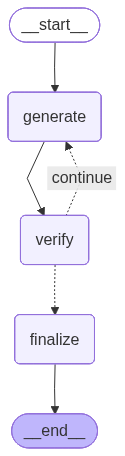

In [3]:
display(Image(cot_agent.get_graph().draw_mermaid_png()))

In [4]:

# Test 1: Math problem
solve_with_cot(
    "A store has 48 books. They sell 1/3 of them in the morning and 1/4 of the remainder in the afternoon. How many books are left?"
)


QUESTION: A store has 48 books. They sell 1/3 of them in the morning and 1/4 of the remainder in the afternoon. How many books are left?

REASONING STEPS:
  Step 1: Calculate the number of books sold in the morning by multiplying the total number of books by 1/3: 48 * (1/3) = 16.
  Step 2: Subtract the number of books sold in the morning from the total number of books to find the remainder: 48 - 16 = 32.
  Step 3: Multiply the remainder by 1/4 to calculate the number of books sold in the afternoon: 32 * (1/4) = 8.

✅ FINAL ANSWER:
  To find the final answer, subtract the total number of books sold from the initial total:

Books sold in morning: 16
Books sold in afternoon: 8
Total books sold: 16 + 8 = 24

Subtract the total books sold from the initial total:
48 - 24 = 24



{'question': 'A store has 48 books. They sell 1/3 of them in the morning and 1/4 of the remainder in the afternoon. How many books are left?',
 'reasoning_steps': ['Calculate the number of books sold in the morning by multiplying the total number of books by 1/3: 48 * (1/3) = 16.',
  'Subtract the number of books sold in the morning from the total number of books to find the remainder: 48 - 16 = 32.',
  'Multiply the remainder by 1/4 to calculate the number of books sold in the afternoon: 32 * (1/4) = 8.'],
 'final_answer': 'To find the final answer, subtract the total number of books sold from the initial total:\n\nBooks sold in morning: 16\nBooks sold in afternoon: 8\nTotal books sold: 16 + 8 = 24\n\nSubtract the total books sold from the initial total:\n48 - 24 = 24',
 'step_count': 3}

In [5]:
# Test 2: Logic problem
solve_with_cot(
    "If all roses are flowers and some flowers are red, can we conclude that some roses are red?"
)



QUESTION: If all roses are flowers and some flowers are red, can we conclude that some roses are red?

REASONING STEPS:
  Step 1: If all A are B and some B are C, then some A are C.
  Step 2: If all A are B and some B are C, then some A are C. 

Therefore, if all roses are flowers and some flowers are red, then some roses are red.
  Step 3: If some A are C, then some A are not C.
  Step 4: If some roses are not red, then some roses are not flowers.
  Step 5: If all roses are flowers and some flowers are not red, then some roses are not flowers.

✅ FINAL ANSWER:
  No, we cannot conclude that some roses are red. The conclusion "some roses are red" is not supported by the given premises.



{'question': 'If all roses are flowers and some flowers are red, can we conclude that some roses are red?',
 'reasoning_steps': ['If all A are B and some B are C, then some A are C.',
  'If all A are B and some B are C, then some A are C. \n\nTherefore, if all roses are flowers and some flowers are red, then some roses are red.',
  'If some A are C, then some A are not C.',
  'If some roses are not red, then some roses are not flowers.',
  'If all roses are flowers and some flowers are not red, then some roses are not flowers.'],
 'final_answer': 'No, we cannot conclude that some roses are red. The conclusion "some roses are red" is not supported by the given premises.',
 'step_count': 5}

In [6]:
from typing import TypedDict, Annotated, Literal
from operator import add
from collections import Counter
from langgraph.graph import StateGraph, END
from langchain_ollama import ChatOllama
from langchain_core.prompts import ChatPromptTemplate

# State definition
class SelfConsistencyState(TypedDict):
    question: str
    reasoning_paths: Annotated[list[dict], add]  # List of {reasoning: str, answer: str}
    num_paths: int
    paths_generated: Annotated[int, add]
    final_answer: str
    confidence: float

# Initialize
llm = ChatOllama(model="llama3.2", temperature=0.8)  # Higher temp for diversity

# Prompt template
reasoning_prompt = ChatPromptTemplate.from_messages([
    ("human", """Question: {question}

Solve this step-by-step. At the end, state your final answer clearly as "Final Answer: [your answer]"

Your reasoning:""")
])

# Create chain
reasoning_chain = reasoning_prompt | llm

# Node: Generate one reasoning path
def generate_path(state: SelfConsistencyState) -> dict:
    """Generate a single reasoning path"""
    
    response = reasoning_chain.invoke({
        "question": state["question"]
    })
    
    reasoning = response.content
    
    # Extract final answer (simple parsing)
    answer = "unknown"
    if "final answer:" in reasoning.lower():
        parts = reasoning.lower().split("final answer:")
        if len(parts) > 1:
            # Get text after "final answer:" and clean it
            answer = parts[1].strip().split('\n')[0].strip()
    
    return {
        "reasoning_paths": [{
            "reasoning": reasoning,
            "answer": answer
        }],
        "paths_generated": 1
    }

# Node: Aggregate answers
def aggregate_answers(state: SelfConsistencyState) -> dict:
    """Find consensus answer from multiple paths"""
    
    # Extract all answers
    answers = [path["answer"] for path in state["reasoning_paths"]]
    
    # Count occurrences
    answer_counts = Counter(answers)
    
    # Get most common answer
    if answer_counts:
        most_common = answer_counts.most_common(1)[0]
        final_answer = most_common[0]
        votes = most_common[1]
        confidence = votes / len(answers)
    else:
        final_answer = "Unable to determine"
        confidence = 0.0
    
    return {
        "final_answer": final_answer,
        "confidence": confidence
    }

# Routing
def should_generate_more(state: SelfConsistencyState) -> str:
    """Decide if we need more reasoning paths"""
    
    if state["paths_generated"] >= state["num_paths"]:
        return "aggregate"
    
    return "generate"

# Build graph
workflow = StateGraph(SelfConsistencyState)

workflow.add_node("generate", generate_path)
workflow.add_node("aggregate", aggregate_answers)

workflow.set_entry_point("generate")

workflow.add_conditional_edges(
    "generate",
    should_generate_more,
    {
        "generate": "generate",  # Generate another path
        "aggregate": "aggregate"  # Done, aggregate results
    }
)

workflow.add_edge("aggregate", END)

# Compile
self_consistency_agent = workflow.compile()

# Test function
def solve_with_self_consistency(question: str, num_paths: int = 3):
    """Solve with multiple reasoning paths"""
    
    initial_state = {
        "question": question,
        "reasoning_paths": [],
        "num_paths": num_paths,
        "paths_generated": 0,
        "final_answer": "",
        "confidence": 0.0
    }
    
    print(f"\n{'='*60}")
    print(f"QUESTION: {question}")
    print(f"{'='*60}\n")
    print(f"Generating {num_paths} reasoning paths...\n")
    
    result = self_consistency_agent.invoke(initial_state)
    
    # Display all paths
    for i, path in enumerate(result["reasoning_paths"], 1):
        print(f"--- PATH {i} ---")
        print(path["reasoning"][:200] + "...")  # Truncate for brevity
        print(f"Answer: {path['answer']}\n")
    
    print(f"{'='*60}")
    print(f"✅ CONSENSUS ANSWER: {result['final_answer']}")
    print(f"   Confidence: {result['confidence']:.1%}")
    print(f"{'='*60}\n")
    
    return result

# Example usage
if __name__ == "__main__":
    solve_with_self_consistency(
        "A farmer has 17 sheep. All but 9 die. How many sheep are left?",
        num_paths=5
    )


QUESTION: A farmer has 17 sheep. All but 9 die. How many sheep are left?

Generating 5 reasoning paths...

--- PATH 1 ---
To solve this problem, we need to subtract the number of sheep that died from the total number of sheep.

Step 1: Identify the total number of sheep initially.
Total number of sheep = 17

Step 2: Iden...
Answer: 8

--- PATH 2 ---
To find out how many sheep are left, we need to subtract the number of sheep that died from the total number of sheep.

Step 1: Identify the total number of sheep
The farmer has a total of 17 sheep.

...
Answer: 9

--- PATH 3 ---
To solve this problem, we need to subtract the number of sheep that did not die (9) from the total number of sheep.

Step 1: Identify the total number of sheep.
Total number of sheep = 17

Step 2: Ide...
Answer: 8

--- PATH 4 ---
To solve this problem, we need to find out how many sheep are left after all but 9 of them died.

Step 1: Determine the number of sheep that died.
The farmer had 17 sheep initially. All b

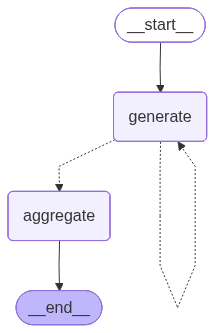

In [7]:
display(Image(self_consistency_agent.get_graph().draw_mermaid_png()))